In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest
from scipy.interpolate import interp1d
import matplotlib as mpl

from qutip import *

from joblib import Parallel, delayed

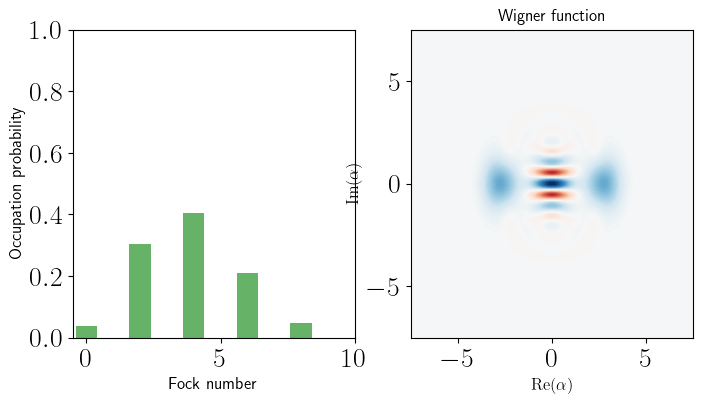

In [3]:
N=10

idc = qeye(N)
ida = qeye(2)
a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2))
sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

# cavity photon number operator
N_cav = tensor(num(N), ida)

# projection operators to qubit ground and excited state
proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())


initial_cavity = coherent(N, 1j*1)

initial_cavity = fock(N,3) 

alpha = 2
initial_cavity = (coherent(N, alpha) + coherent(N,-alpha)).unit()

#initial_cavity = (fock(N, 1) + fock(N,2)).unit()

psi0 = tensor(initial_cavity, basis(2,0))

n_init = expect(N_cav, psi0)

plot_wigner_fock_distribution(initial_cavity);

In [4]:
def U_interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

## Params

In [5]:
Nmeas = 100
Ntrajs = 1000

g = 4
gamma = g**2
dt = 0.005

nsteps = np.linspace(0,Nmeas-1,Nmeas)
tlist = nsteps*dt

In [6]:
k=5
x=np.linspace(-k,k,500)

# ideal distribution from Wigner marginal
x=np.linspace(-5,5,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x, axis=0)

# ideal cdf from marginal
cdf = np.cumsum(marginal)*dx
cdf_func = interp1d(x, cdf, fill_value="extrapolate")

In [7]:
# Select quadrature
rotangl = 0
qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

### Lossy system

In [36]:
dt_total = 0.5

In [40]:
# generate interaction Hamiltonian with strength gint
#U_int = H_int(g, delta_t)

kappa = 0.02

# get measurement histogram for one homodyne angle
def get_measurements_lossy(rotangl, Ntrajs, theta):
        
    # loss operator
    L = liouvillian(0*a, [np.sqrt(kappa*dt_total)*a])
    op = L.expm()
    
    ### simulate tomography ###
    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    quadmeashom = []
    
    def g_timedep(i):
        return np.exp(theta*(i))
    
    def calc_weights(step):
        g_timedep_list = np.array([g_timedep(i) for i in range(step+1)])
        exponent = np.trapz(g_timedep_list**2,dx=dt)
        return  g_timedep(step)*np.sqrt(gamma*dt/2)*np.exp(-gamma*exponent/2)

    calculated_weights = np.array([calc_weights(step) for step in range(Nmeas)])

    for j in range(Ntrajs):
        xrnd = prng.rand(Nmeas)

        results = []
        psi = ket2dm(psi0)

        for i in range(Nmeas):
            U_int = U_interact(g*g_timedep(i)*np.sqrt(dt))
            U = qbrotmat * U_int
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)          

            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)

            if prob > xrnd[i]:
                # measured g
                #results.append(-1 if error[i] <= correct_prob else 1) 
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                #results.append(1 if error[i] <= correct_prob else -1)
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
    
        quadmeashom.append(np.sum(results*calculated_weights))

    return quadmeashom, psi.ptrace(0)[0,0].real    

In [41]:
%%time

nr_stats =  10 # number of times to run statistics

# seed 
prng = np.random.RandomState(12775425)

theta_list = np.concatenate((np.linspace(0.001, 0.009, 8), np.linspace(0.01,0.05,5)))

list_mean_ks_loss = []
list_var_ks_loss = []

mean_vacuum_pops = []

#all_ks = np.zeros((len(probs), nr_stats))
for idx, theta in enumerate(theta_list):
    print("theta", theta)
    ks_stats = []
    vacuum_pops = []
    for nr in range(nr_stats):
        measurements, f_cavity_vac = get_measurements_lossy(rotangl,Ntrajs, theta)
        ks_stat = kstest(measurements, cdf_func)[0]
        ks_stats.append(ks_stat)
        #all_ks[idx,nr] = ks_stat 
        
        vacuum_pops.append(f_cavity_vac)
        #print(f_cavity_vac)

    mean_ks = np.mean(ks_stats)
    var_ks = np.var(ks_stats)
    list_mean_ks_loss.append(mean_ks)
    list_var_ks_loss.append(var_ks)
    
    mean_vacuum_pops.append(np.mean(vacuum_pops))

theta 0.001
theta 0.002142857142857143
theta 0.003285714285714286
theta 0.004428571428571429
theta 0.005571428571428572
theta 0.006714285714285715
theta 0.007857142857142858
theta 0.009
theta 0.01
theta 0.02
theta 0.03
theta 0.04
theta 0.05
CPU times: user 12d 20h 41min 52s, sys: 5min 10s, total: 12d 20h 47min 3s
Wall time: 10h 33min 12s


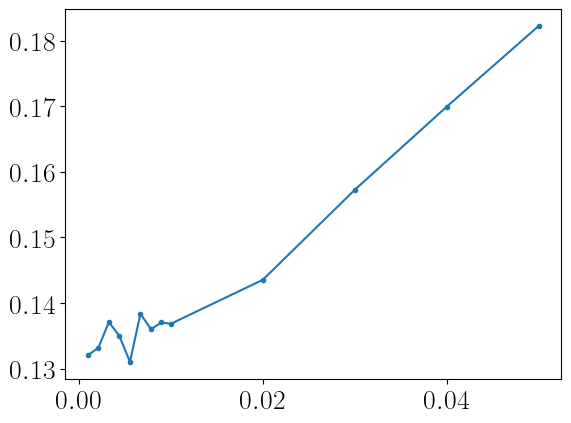

In [42]:
plt.plot(theta_list, list_mean_ks_loss,'.-');

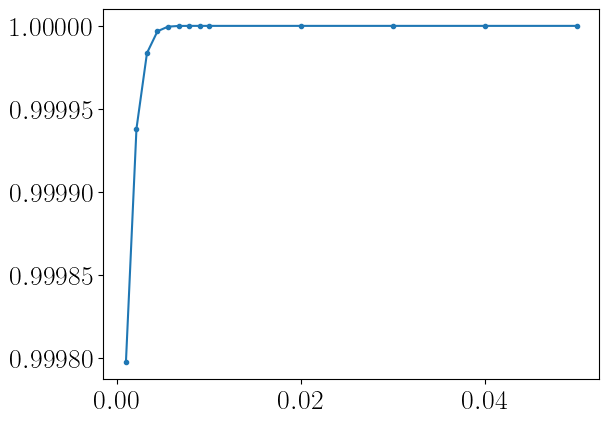

In [43]:
plt.plot(theta_list, mean_vacuum_pops,'.-');

In [44]:
np.savetxt('homodyne_g4_dt0.005_dt_tot0.5_Ntrajs1000_Nmeas100_stats10_kappa0.02_loopTHETA_exp_catAlpha2_4.dat', np.c_[theta_list, list_mean_ks_loss, mean_vacuum_pops], header='theta ks vac')

## Closed system

In [8]:
# Repeated homodyne detection: calculate single homodyne shots and collect statistics
def get_measurements(rotangl, Ntrajs, theta):

    def g_timedep(i):
        return 0.5*np.exp(theta*(i))
    
    def calc_weights(step):
        g_timedep_list = np.array([g_timedep(i) for i in range(step+1)])
        exponent = np.trapz(g_timedep_list**2,dx=dt)
        return  g_timedep(step)*np.sqrt(gamma*dt/2)*np.exp(-gamma*exponent/2)

    calculated_weights = np.array([calc_weights(step) for step in range(Nmeas)])
    
    measurements = []
    for j in range(Ntrajs):
        xrnd = np.random.rand(Nmeas)

        results = []
        psi = psi0

        for i in range(Nmeas):
            U_int = U_interact(g*g_timedep(i)*np.sqrt(dt))
            psi = qbrotmat * (U_int * psi)

            prob = expect(proj0,psi) # prob gs
            if prob>xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi

        measurements.append(np.sum(results*calculated_weights))
        
    return measurements, psi.ptrace(0)[0,0].real

In [9]:
np.concatenate((np.linspace(0.001, 0.009, 6), np.linspace(0.01,0.05,5)))

array([0.001 , 0.0026, 0.0042, 0.0058, 0.0074, 0.009 , 0.01  , 0.02  ,
       0.03  , 0.04  , 0.05  ])

In [10]:
%%time

nr_stats =  10 # number of times to run statistics

# seed 
prng = np.random.RandomState(12775425)

theta_list  =np.linspace(0.01, 0.1, 15)


theta_list = np.concatenate((np.linspace(0.001, 0.009, 8), np.linspace(0.01,0.05,5)))
#theta_list = [0.25]

list_mean_ks_loss = []
list_var_ks_loss = []

mean_vacuum_pops = []

#all_ks = np.zeros((len(probs), nr_stats))
for idx, theta in enumerate(theta_list):
    
    ks_stats = []
    vacuum_pops = []
    
    def get_stats_func():
        measurements, vac = get_measurements(rotangl,Ntrajs, theta)
        ks_stat = kstest(measurements, cdf_func)[0]
        return ks_stat, vac
    
    results = Parallel(n_jobs=nr_stats)(delayed(get_stats_func)() for i in range(nr_stats))
    ks_stats = np.array(results)[:,0]
    mean_ks = np.mean(ks_stats)
    
    vacuum_pops = np.array(results)[:,1]
    list_mean_ks_loss.append(mean_ks)

    print("theta", theta, 'ks', mean_ks)
    mean_vacuum_pops.append(np.mean(vacuum_pops))

theta 0.001 ks 0.14031070180705071
theta 0.002142857142857143 ks 0.11611984938778522
theta 0.003285714285714286 ks 0.09033324882199087
theta 0.004428571428571429 ks 0.06870000946029979
theta 0.005571428571428572 ks 0.06516261286411668
theta 0.006714285714285715 ks 0.06116834085948457
theta 0.007857142857142858 ks 0.05441031989802164
theta 0.009 ks 0.050502086798225945
theta 0.01 ks 0.051233576909371616
theta 0.02 ks 0.05510518205382908
theta 0.03 ks 0.07463037152377205
theta 0.04 ks 0.08168734793101037
theta 0.05 ks 0.09825572960348225
CPU times: user 388 ms, sys: 98.2 ms, total: 486 ms
Wall time: 28min 16s


array([0.001     , 0.00214286, 0.00328571, 0.00442857, 0.00557143,
       0.00671429, 0.00785714, 0.009     , 0.01      , 0.02      ,
       0.03      , 0.04      , 0.05      ])

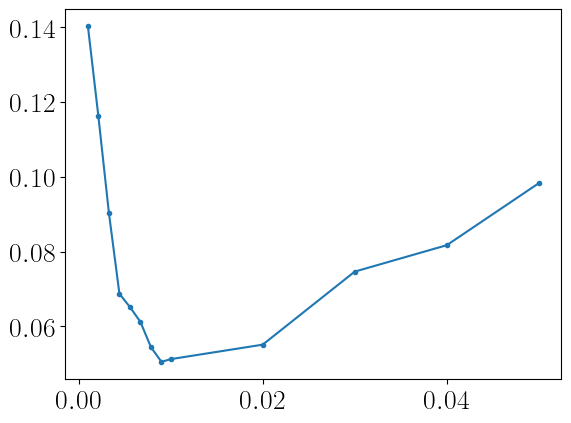

In [11]:
plt.plot(theta_list, list_mean_ks_loss,'.-');
theta_list

array([0.001     , 0.00214286, 0.00328571, 0.00442857, 0.00557143,
       0.00671429, 0.00785714, 0.009     , 0.01      , 0.02      ,
       0.03      , 0.04      , 0.05      ])

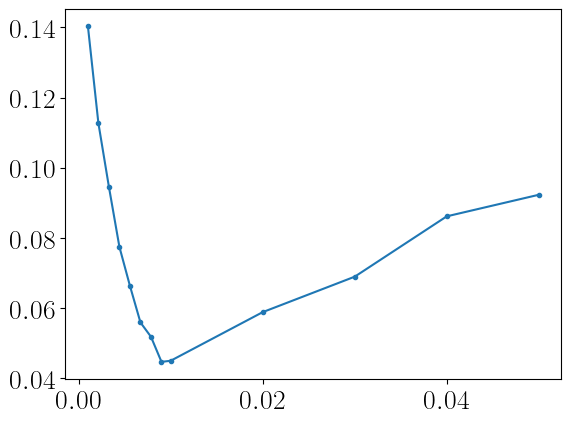

In [30]:
plt.plot(theta_list, list_mean_ks_loss,'.-');
theta_list

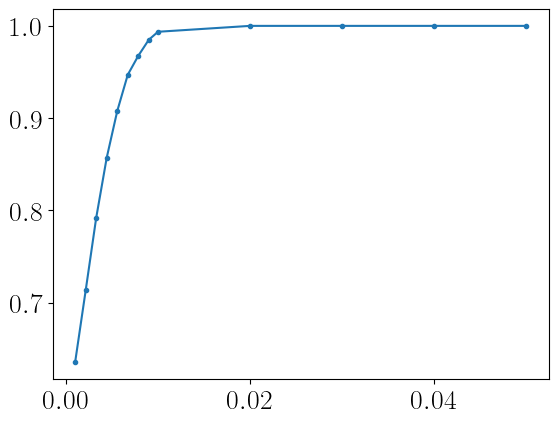

In [31]:
plt.plot(theta_list, mean_vacuum_pops,'.-');

In [32]:
np.savetxt('homodyne_g4_dt0.005_Ntrajs1000_Nmeas100_stats10_kappa0_loopTHETA_exp_catAlpha2_4.dat', np.c_[theta_list, list_mean_ks_loss, mean_vacuum_pops], header='theta ks vac')

In [19]:
k=5
plt.hist(np.array(measurements),60,[-k,k],density=True, edgecolor='k');
plt.plot(x, marginal, 'C1--',linewidth=2)

ks_stat = kstest(measurements, cdf_func)[0]
ks_stat

NameError: name 'measurements' is not defined

In [ ]:
theta_list2, list_mean_ks_loss2, mean_vacuum_pops2 = np.loadtxt('homodyne_g0.25_dt0.5_Ntrajs1000_Nmeas100_stats10_kappa0_loopTHETA_exp_FOCK4_GOOD.dat').T
plt.plot(theta_list2, list_mean_ks_loss2,'.-');
#plt.plot(theta_list2, mean_vacuum_pops2,'.');

In [ ]:
plt.plot(theta_list2, list_mean_ks_loss2,'.');
theta_list2